# 🏜️ Duality AI's Offroad Semantic Scene Segmentation

## Challenge Overview
This notebook implements a complete pipeline for the **Offroad Autonomy Segmentation Challenge** - training semantic segmentation models on synthetic desert environment data.

### Classes (10 total):
| ID | Class Name | Description |
|---|---|---|
| 100 | Trees | Tree vegetation |
| 200 | Lush Bushes | Green, healthy bushes |
| 300 | Dry Grass | Dried grass |
| 500 | Dry Bushes | Dried bushes |
| 550 | Ground Clutter | Small debris on ground |
| 600 | Flowers | Flowering plants |
| 700 | Logs | Fallen logs |
| 800 | Rocks | Rock formations |
| 7100 | Landscape | General ground |
| 10000 | Sky | Sky region |

---

## 1. Import Required Libraries

In [8]:
# Install required packages (uncomment if needed)
# !pip install torch torchvision segmentation-models-pytorch albumentations opencv-python tqdm

import os
import glob
import random
import warnings
from collections import defaultdict
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm  # Changed from tqdm.notebook to tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import GradScaler, autocast

import torchvision.transforms.functional as TF
import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cpu


In [9]:
# Define class mapping and colors
CLASS_INFO = {
    100: {'name': 'Trees', 'color': (34, 139, 34)},       # Forest Green
    200: {'name': 'Lush Bushes', 'color': (0, 255, 0)},   # Lime Green
    300: {'name': 'Dry Grass', 'color': (189, 183, 107)}, # Dark Khaki
    500: {'name': 'Dry Bushes', 'color': (139, 119, 101)},# Rosy Brown
    550: {'name': 'Ground Clutter', 'color': (160, 82, 45)}, # Sienna
    600: {'name': 'Flowers', 'color': (255, 105, 180)},   # Hot Pink
    700: {'name': 'Logs', 'color': (139, 69, 19)},        # Saddle Brown
    800: {'name': 'Rocks', 'color': (128, 128, 128)},     # Gray
    7100: {'name': 'Landscape', 'color': (210, 180, 140)},# Tan
    10000: {'name': 'Sky', 'color': (135, 206, 235)}      # Sky Blue
}

# Original class IDs
ORIGINAL_CLASS_IDS = [100, 200, 300, 500, 550, 600, 700, 800, 7100, 10000]
NUM_CLASSES = len(ORIGINAL_CLASS_IDS)

# Create mapping from original IDs to contiguous indices (0-9)
ID_TO_INDEX = {class_id: idx for idx, class_id in enumerate(ORIGINAL_CLASS_IDS)}
INDEX_TO_ID = {idx: class_id for class_id, idx in ID_TO_INDEX.items()}

# Class names for plotting
CLASS_NAMES = [CLASS_INFO[cid]['name'] for cid in ORIGINAL_CLASS_IDS]

print(f"Number of classes: {NUM_CLASSES}")
print(f"\nClass Mapping (Original ID -> Index):")
for cid, idx in ID_TO_INDEX.items():
    print(f"  {cid:5d} ({CLASS_INFO[cid]['name']:15s}) -> {idx}")

Number of classes: 10

Class Mapping (Original ID -> Index):
    100 (Trees          ) -> 0
    200 (Lush Bushes    ) -> 1
    300 (Dry Grass      ) -> 2
    500 (Dry Bushes     ) -> 3
    550 (Ground Clutter ) -> 4
    600 (Flowers        ) -> 5
    700 (Logs           ) -> 6
    800 (Rocks          ) -> 7
   7100 (Landscape      ) -> 8
  10000 (Sky            ) -> 9


## 2. Dataset Loading and Structure Exploration

In [10]:
# Define dataset paths
BASE_PATH = r"d:\Semantic_Segmentation"

TRAIN_IMG_DIR = os.path.join(BASE_PATH, "Offroad_Segmentation_Training_Dataset", 
                              "Offroad_Segmentation_Training_Dataset", "train", "Color_Images")
TRAIN_MASK_DIR = os.path.join(BASE_PATH, "Offroad_Segmentation_Training_Dataset", 
                               "Offroad_Segmentation_Training_Dataset", "train", "Segmentation")

VAL_IMG_DIR = os.path.join(BASE_PATH, "Offroad_Segmentation_Training_Dataset", 
                            "Offroad_Segmentation_Training_Dataset", "val", "Color_Images")
VAL_MASK_DIR = os.path.join(BASE_PATH, "Offroad_Segmentation_Training_Dataset", 
                             "Offroad_Segmentation_Training_Dataset", "val", "Segmentation")

TEST_IMG_DIR = os.path.join(BASE_PATH, "Offroad_Segmentation_testImages", 
                             "Offroad_Segmentation_testImages", "Color_Images")
TEST_MASK_DIR = os.path.join(BASE_PATH, "Offroad_Segmentation_testImages", 
                              "Offroad_Segmentation_testImages", "Segmentation")

# Verify paths exist
paths_to_check = {
    'Train Images': TRAIN_IMG_DIR,
    'Train Masks': TRAIN_MASK_DIR,
    'Val Images': VAL_IMG_DIR,
    'Val Masks': VAL_MASK_DIR,
    'Test Images': TEST_IMG_DIR,
    'Test Masks': TEST_MASK_DIR
}

print("Checking dataset paths...")
for name, path in paths_to_check.items():
    exists = os.path.exists(path)
    count = len(glob.glob(os.path.join(path, "*.png"))) if exists else 0
    status = "✓" if exists else "✗"
    print(f"  {status} {name}: {path}")
    if exists:
        print(f"      Found {count} images")

Checking dataset paths...
  ✓ Train Images: d:\Semantic_Segmentation\Offroad_Segmentation_Training_Dataset\Offroad_Segmentation_Training_Dataset\train\Color_Images  ✓ Train Images: d:\Semantic_Segmentation\Offroad_Segmentation_Training_Dataset\Offroad_Segmentation_Training_Dataset\train\Color_Images


      Found 2857 images
  ✓ Train Masks: d:\Semantic_Segmentation\Offroad_Segmentation_Training_Dataset\Offroad_Segmentation_Training_Dataset\train\Segmentation
      Found 2857 images
  ✓ Val Images: d:\Semantic_Segmentation\Offroad_Segmentation_Training_Dataset\Offroad_Segmentation_Training_Dataset\val\Color_Images
      Found 317 images
  ✓ Val Masks: d:\Semantic_Segmentation\Offroad_Segmentation_Training_Dataset\Offroad_Segmentation_Training_Dataset\val\Segmentation
      Found 317 images
  ✓ Test Images: d:\Semantic_Segmentation\Offroad_Segmentation_testImages\Offroad_Segmentation_testImages\Color_Images
      Found 1002 images
  ✓ Test Masks: d:\Semantic_Segmentation\Offroad_Segmentation_testImages\Offroad_Segmentation_testImages\Segmentation
      Found 1002 images
  ✓ Train Masks: d:\Semantic_Segmentation\Offroad_Segmentation_Training_Dataset\Offroad_Segmentation_Training_Dataset\train\Segmentation
      Found 2857 images
  ✓ Val Images: d:\Semantic_Segmentation\Offroad_Segmen

In [11]:
# Get image and mask file lists
def get_image_mask_pairs(img_dir: str, mask_dir: str) -> List[Tuple[str, str]]:
    """Get paired image and mask file paths."""
    img_files = sorted(glob.glob(os.path.join(img_dir, "*.png")))
    pairs = []
    
    for img_path in img_files:
        filename = os.path.basename(img_path)
        mask_path = os.path.join(mask_dir, filename)
        
        if os.path.exists(mask_path):
            pairs.append((img_path, mask_path))
        else:
            print(f"Warning: No mask found for {filename}")
    
    return pairs

# Get all pairs
train_pairs = get_image_mask_pairs(TRAIN_IMG_DIR, TRAIN_MASK_DIR)
val_pairs = get_image_mask_pairs(VAL_IMG_DIR, VAL_MASK_DIR)
test_pairs = get_image_mask_pairs(TEST_IMG_DIR, TEST_MASK_DIR)

print(f"\n📊 Dataset Statistics:")
print(f"  Training pairs: {len(train_pairs)}")
print(f"  Validation pairs: {len(val_pairs)}")
print(f"  Test pairs: {len(test_pairs)}")
print(f"  Total: {len(train_pairs) + len(val_pairs) + len(test_pairs)}")


📊 Dataset Statistics:
  Training pairs: 2857
  Validation pairs: 317
  Test pairs: 1002
  Total: 4176


## 3. Class Distribution Analysis

In [12]:
def analyze_class_distribution(pairs: List[Tuple[str, str]], 
                                sample_size: int = None,
                                desc: str = "Analyzing") -> Dict:
    """Analyze pixel-wise class distribution in masks."""
    class_pixel_counts = defaultdict(int)
    total_pixels = 0
    unique_values_found = set()
    
    # Optionally sample for faster analysis
    if sample_size and sample_size < len(pairs):
        pairs_to_analyze = random.sample(pairs, sample_size)
    else:
        pairs_to_analyze = pairs
    
    for _, mask_path in tqdm(pairs_to_analyze, desc=desc):
        mask = np.array(Image.open(mask_path))
        
        # Handle RGB masks - use first channel or convert to grayscale
        if len(mask.shape) == 3:
            # The masks appear to store class IDs, check each channel
            mask = mask[:, :, 0]  # Use first channel
        
        unique_values = np.unique(mask)
        unique_values_found.update(unique_values.tolist())
        
        for class_id in ORIGINAL_CLASS_IDS:
            count = np.sum(mask == class_id)
            class_pixel_counts[class_id] += count
        
        total_pixels += mask.size
    
    return {
        'class_counts': dict(class_pixel_counts),
        'total_pixels': total_pixels,
        'unique_values': sorted(unique_values_found)
    }

# Analyze training set (sample for speed)
print("Analyzing class distribution in training set...")
train_distribution = analyze_class_distribution(train_pairs, sample_size=200, desc="Train")

print(f"\nUnique values found in masks: {train_distribution['unique_values']}")

Analyzing class distribution in training set...


Train: 100%|██████████| 200/200 [00:13<00:00, 14.99it/s]


Unique values found in masks: [100, 200, 300, 500, 550, 600, 700, 800, 7100, 10000]


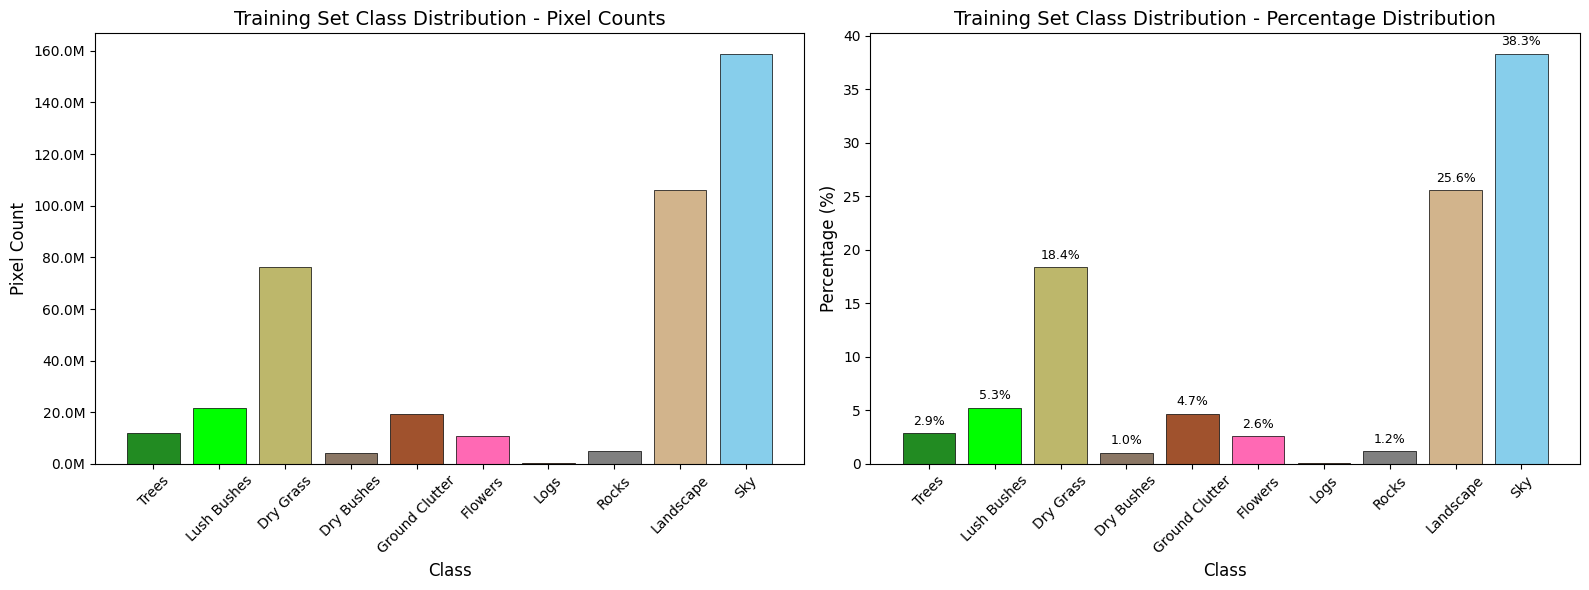


📊 Training Set Class Distribution:
------------------------------------------------------------
Class                    Pixel Count   Percentage
------------------------------------------------------------
Trees                     12,015,022        2.90%
Lush Bushes               21,777,242        5.25%
Dry Grass                 76,263,998       18.39%
Dry Bushes                 4,329,109        1.04%
Ground Clutter            19,457,682        4.69%
Flowers                   10,633,241        2.56%
Logs                         309,674        0.07%
Rocks                      4,948,083        1.19%
Landscape                106,143,791       25.59%
Sky                      158,842,158       38.30%
------------------------------------------------------------
Total                    414,720,000      100.00%


In [13]:
# Visualize class distribution
def plot_class_distribution(distribution: Dict, title: str = "Class Distribution"):
    """Plot bar chart of class pixel distribution."""
    class_counts = distribution['class_counts']
    total = distribution['total_pixels']
    
    # Prepare data
    classes = []
    counts = []
    percentages = []
    colors = []
    
    for class_id in ORIGINAL_CLASS_IDS:
        count = class_counts.get(class_id, 0)
        classes.append(CLASS_INFO[class_id]['name'])
        counts.append(count)
        percentages.append(100 * count / total if total > 0 else 0)
        colors.append(np.array(CLASS_INFO[class_id]['color']) / 255)
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar plot - pixel counts
    ax1 = axes[0]
    bars1 = ax1.bar(classes, counts, color=colors, edgecolor='black', linewidth=0.5)
    ax1.set_xlabel('Class', fontsize=12)
    ax1.set_ylabel('Pixel Count', fontsize=12)
    ax1.set_title(f'{title} - Pixel Counts', fontsize=14)
    ax1.tick_params(axis='x', rotation=45)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
    
    # Bar plot - percentages
    ax2 = axes[1]
    bars2 = ax2.bar(classes, percentages, color=colors, edgecolor='black', linewidth=0.5)
    ax2.set_xlabel('Class', fontsize=12)
    ax2.set_ylabel('Percentage (%)', fontsize=12)
    ax2.set_title(f'{title} - Percentage Distribution', fontsize=14)
    ax2.tick_params(axis='x', rotation=45)
    
    # Add percentage labels on bars
    for bar, pct in zip(bars2, percentages):
        if pct > 0.5:  # Only label if > 0.5%
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print(f"\n📊 {title}:")
    print("-" * 60)
    print(f"{'Class':<20} {'Pixel Count':>15} {'Percentage':>12}")
    print("-" * 60)
    for i, class_id in enumerate(ORIGINAL_CLASS_IDS):
        print(f"{CLASS_INFO[class_id]['name']:<20} {counts[i]:>15,} {percentages[i]:>11.2f}%")
    print("-" * 60)
    print(f"{'Total':<20} {total:>15,} {100.0:>11.2f}%")

plot_class_distribution(train_distribution, "Training Set Class Distribution")

## 4. Image and Mask Visualization

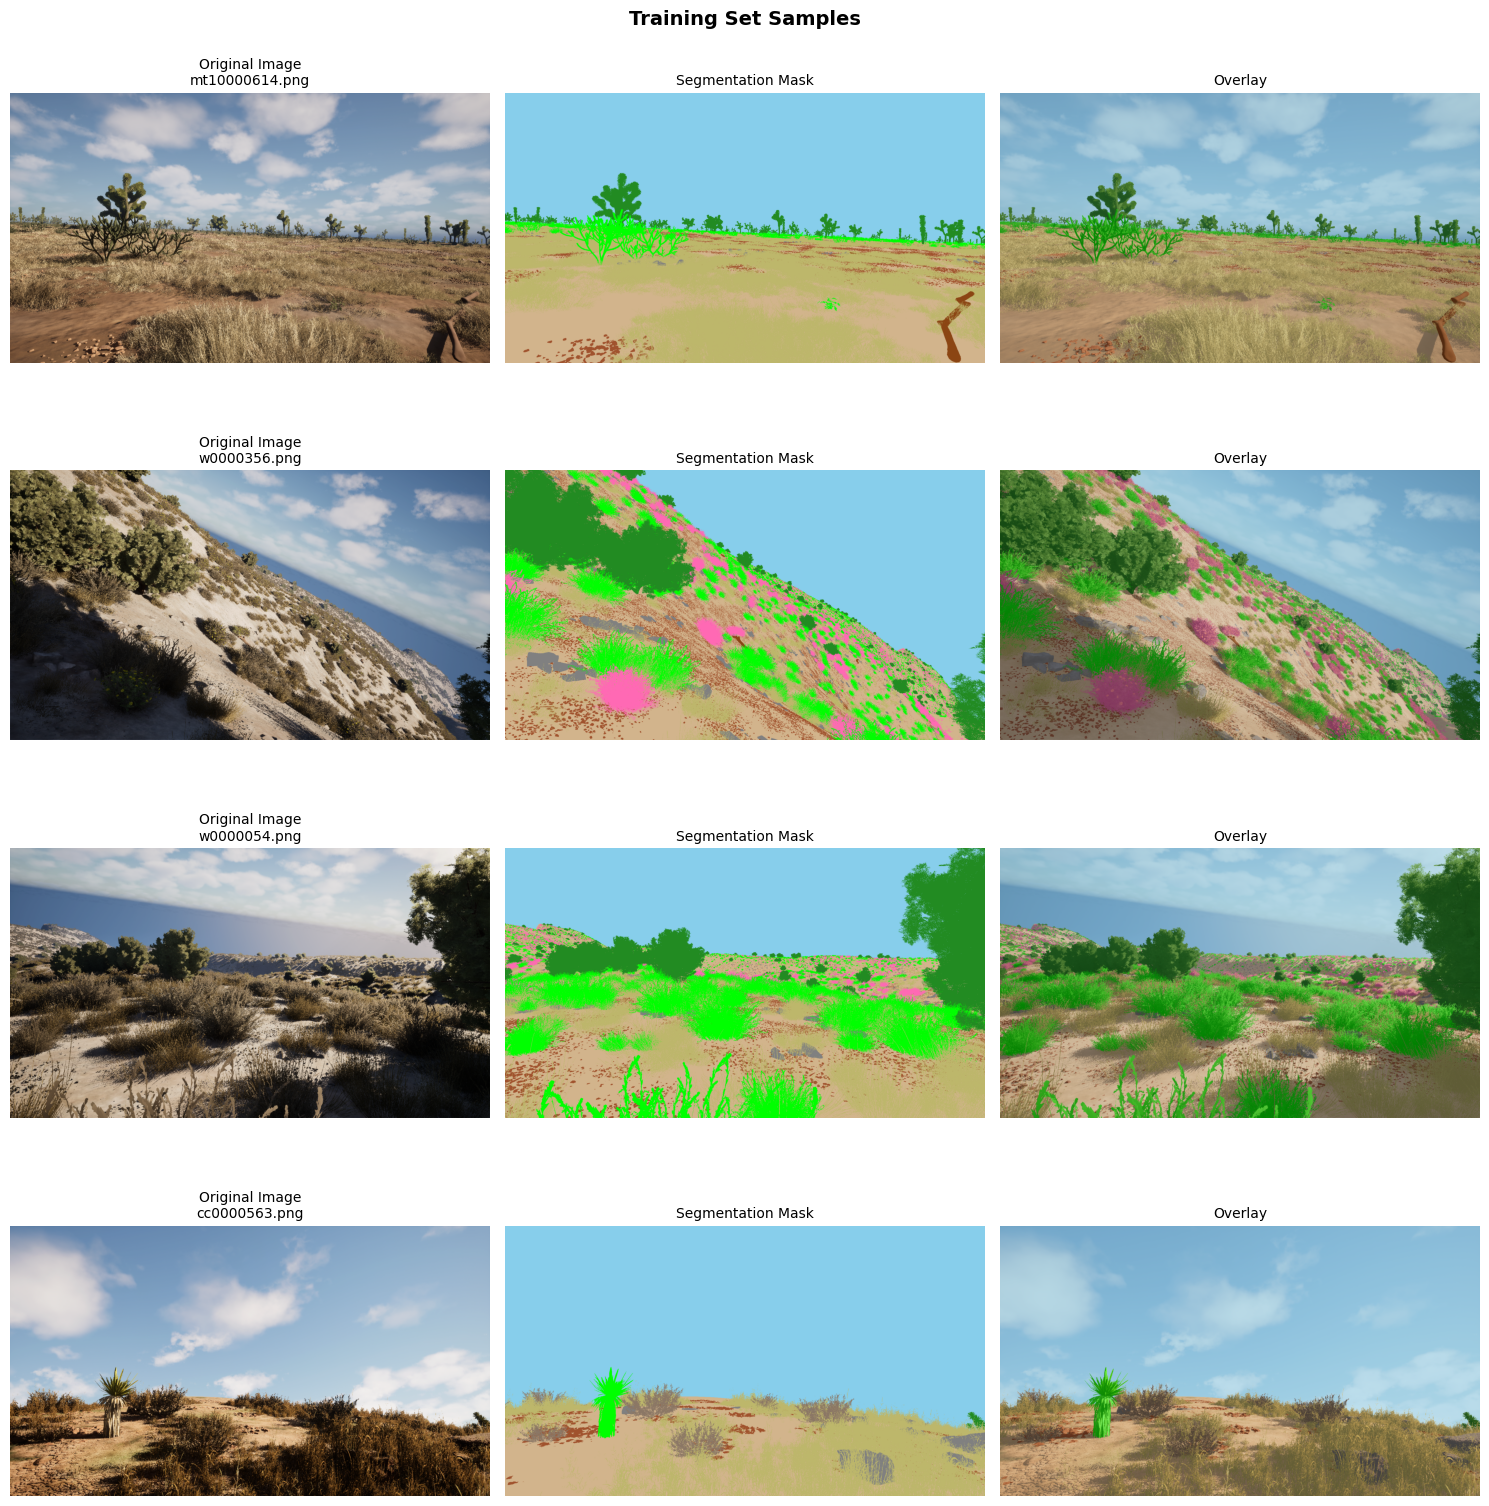

In [14]:
def mask_to_rgb(mask: np.ndarray) -> np.ndarray:
    """Convert class ID mask to RGB visualization."""
    if len(mask.shape) == 3:
        mask = mask[:, :, 0]
    
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    
    for class_id, info in CLASS_INFO.items():
        rgb[mask == class_id] = info['color']
    
    return rgb

def visualize_samples(pairs: List[Tuple[str, str]], 
                      num_samples: int = 4, 
                      random_sample: bool = True,
                      title: str = "Sample Images"):
    """Visualize sample images with their masks."""
    if random_sample:
        sample_pairs = random.sample(pairs, min(num_samples, len(pairs)))
    else:
        sample_pairs = pairs[:num_samples]
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4 * num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (img_path, mask_path) in enumerate(sample_pairs):
        img = np.array(Image.open(img_path))
        mask = np.array(Image.open(mask_path))
        if len(mask.shape) == 3:
            mask = mask[:, :, 0]
        mask_rgb = mask_to_rgb(mask)
        
        # Original image
        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title(f'Original Image\n{os.path.basename(img_path)}', fontsize=10)
        axes[idx, 0].axis('off')
        
        # Mask
        axes[idx, 1].imshow(mask_rgb)
        axes[idx, 1].set_title('Segmentation Mask', fontsize=10)
        axes[idx, 1].axis('off')
        
        # Overlay
        overlay = img.copy()
        alpha = 0.5
        overlay = (overlay * (1 - alpha) + mask_rgb * alpha).astype(np.uint8)
        axes[idx, 2].imshow(overlay)
        axes[idx, 2].set_title('Overlay', fontsize=10)
        axes[idx, 2].axis('off')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize training samples
visualize_samples(train_pairs, num_samples=4, title="Training Set Samples")

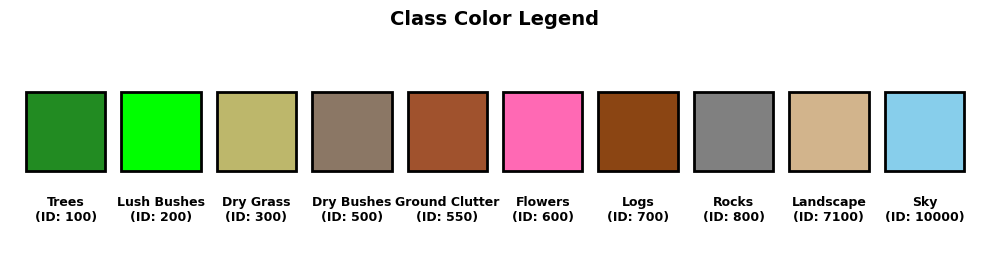

In [15]:
# Create legend for class colors
def create_class_legend():
    """Create a legend showing all class colors."""
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    
    # Create color patches
    for i, class_id in enumerate(ORIGINAL_CLASS_IDS):
        color = np.array(CLASS_INFO[class_id]['color']) / 255
        name = CLASS_INFO[class_id]['name']
        
        # Draw rectangle
        rect = plt.Rectangle((i * 1.2, 0), 1, 1, facecolor=color, edgecolor='black', linewidth=2)
        ax.add_patch(rect)
        
        # Add label
        ax.text(i * 1.2 + 0.5, -0.3, f'{name}\n(ID: {class_id})', 
                ha='center', va='top', fontsize=9, fontweight='bold')
    
    ax.set_xlim(-0.2, len(ORIGINAL_CLASS_IDS) * 1.2)
    ax.set_ylim(-1, 1.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Class Color Legend', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

create_class_legend()

## 5. Pixel-Level Class Statistics

Computing stats: 100%|██████████| 200/200 [00:08<00:00, 23.77it/s]



📊 Per-Image Class Coverage Statistics (% of image pixels):
        Trees  Lush Bushes  Dry Grass  Dry Bushes  Ground Clutter  Flowers    Logs   Rocks  Landscape     Sky
count  200.00       200.00     200.00      200.00          200.00   200.00  200.00  200.00     200.00  200.00
mean     3.05         4.97      19.14        1.32            4.47     2.79    0.07    1.24      24.98   37.96
std      4.12         6.75      10.68        2.19            2.96     5.13    0.14    1.39      16.27   18.40
min      0.00         0.00       0.00        0.00            0.32     0.00    0.00    0.00       2.95    0.00
25%      0.00         0.11      10.09        0.00            1.78     0.00    0.00    0.35      12.43   31.16
50%      1.05         2.23      18.13        0.00            4.16     0.00    0.00    0.91      20.23   44.07
75%      5.34         8.39      26.83        2.28            6.62     3.88    0.11    1.60      32.00   48.78
max     19.04        41.67      44.66       10.40           1

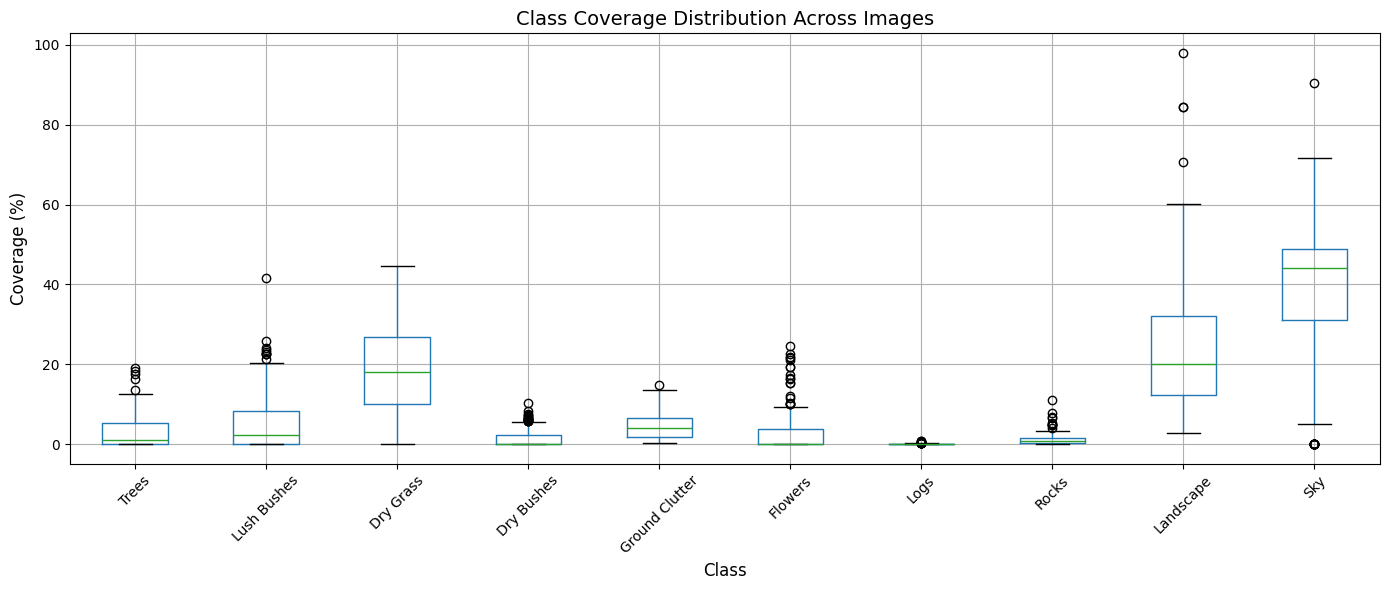

In [16]:
def compute_per_image_class_stats(pairs: List[Tuple[str, str]], 
                                   sample_size: int = 100) -> pd.DataFrame:
    """Compute per-image class statistics."""
    if sample_size and sample_size < len(pairs):
        pairs_sample = random.sample(pairs, sample_size)
    else:
        pairs_sample = pairs
    
    records = []
    
    for img_path, mask_path in tqdm(pairs_sample, desc="Computing stats"):
        mask = np.array(Image.open(mask_path))
        if len(mask.shape) == 3:
            mask = mask[:, :, 0]
        
        total_pixels = mask.size
        
        record = {'filename': os.path.basename(img_path)}
        for class_id in ORIGINAL_CLASS_IDS:
            count = np.sum(mask == class_id)
            record[CLASS_INFO[class_id]['name']] = count / total_pixels * 100
        
        records.append(record)
    
    return pd.DataFrame(records)

# Compute stats
class_stats_df = compute_per_image_class_stats(train_pairs, sample_size=200)

# Summary statistics
print("📊 Per-Image Class Coverage Statistics (% of image pixels):")
print("=" * 80)
summary = class_stats_df.drop('filename', axis=1).describe()
print(summary.round(2).to_string())

# Box plot
plt.figure(figsize=(14, 6))
class_stats_df.drop('filename', axis=1).boxplot(rot=45)
plt.title('Class Coverage Distribution Across Images', fontsize=14)
plt.ylabel('Coverage (%)', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.tight_layout()
plt.show()

## 6. Image Properties Analysis

In [17]:
def analyze_image_properties(pairs: List[Tuple[str, str]], 
                             sample_size: int = 100) -> Dict:
    """Analyze image dimensions and RGB statistics."""
    if sample_size and sample_size < len(pairs):
        pairs_sample = random.sample(pairs, sample_size)
    else:
        pairs_sample = pairs
    
    heights, widths = [], []
    r_means, g_means, b_means = [], [], []
    r_stds, g_stds, b_stds = [], [], []
    
    for img_path, _ in tqdm(pairs_sample, desc="Analyzing images"):
        img = np.array(Image.open(img_path))
        
        h, w = img.shape[:2]
        heights.append(h)
        widths.append(w)
        
        # RGB statistics (normalize to 0-1)
        img_float = img.astype(np.float32) / 255.0
        r_means.append(img_float[:, :, 0].mean())
        g_means.append(img_float[:, :, 1].mean())
        b_means.append(img_float[:, :, 2].mean())
        r_stds.append(img_float[:, :, 0].std())
        g_stds.append(img_float[:, :, 1].std())
        b_stds.append(img_float[:, :, 2].std())
    
    return {
        'heights': heights,
        'widths': widths,
        'mean': [np.mean(r_means), np.mean(g_means), np.mean(b_means)],
        'std': [np.mean(r_stds), np.mean(g_stds), np.mean(b_stds)]
    }

# Analyze images
img_props = analyze_image_properties(train_pairs, sample_size=100)

print("📐 Image Properties Analysis:")
print("=" * 50)
print(f"Height: min={min(img_props['heights'])}, max={max(img_props['heights'])}, "
      f"unique={len(set(img_props['heights']))}")
print(f"Width:  min={min(img_props['widths'])}, max={max(img_props['widths'])}, "
      f"unique={len(set(img_props['widths']))}")
print(f"\n🎨 RGB Channel Statistics (normalized 0-1):")
print(f"Mean: R={img_props['mean'][0]:.4f}, G={img_props['mean'][1]:.4f}, B={img_props['mean'][2]:.4f}")
print(f"Std:  R={img_props['std'][0]:.4f}, G={img_props['std'][1]:.4f}, B={img_props['std'][2]:.4f}")

# Store for later use in transforms
IMG_MEAN = img_props['mean']
IMG_STD = img_props['std']
print(f"\n📝 Use these for normalization:")
print(f"IMG_MEAN = {IMG_MEAN}")
print(f"IMG_STD = {IMG_STD}")

Analyzing images:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing images: 100%|██████████| 100/100 [00:08<00:00, 12.11it/s]

📐 Image Properties Analysis:
Height: min=1080, max=1080, unique=1
Width:  min=1920, max=1920, unique=1

🎨 RGB Channel Statistics (normalized 0-1):
Mean: R=0.4957, G=0.4795, B=0.4594
Std:  R=0.2327, G=0.2396, B=0.2761

📝 Use these for normalization:
IMG_MEAN = [np.float32(0.4956785), np.float32(0.47951436), np.float32(0.45944408)]
IMG_STD = [np.float32(0.23266274), np.float32(0.23956123), np.float32(0.276144)]


## 7. Class Imbalance Assessment and Weights

📊 Class Weights for Loss Function:
Class                   Frequency       Weight
------------------------------------------------------------
Trees                    0.028971       0.7116
Lush Bushes              0.052511       0.5286
Dry Grass                0.183893       0.2824
Dry Bushes               0.010439       1.1855
Ground Clutter           0.046918       0.5592
Flowers                  0.025640       0.7564
Logs                     0.000747       4.4323
Rocks                    0.011931       1.1089
Landscape                0.255941       0.2394
Sky                      0.383011       0.1957


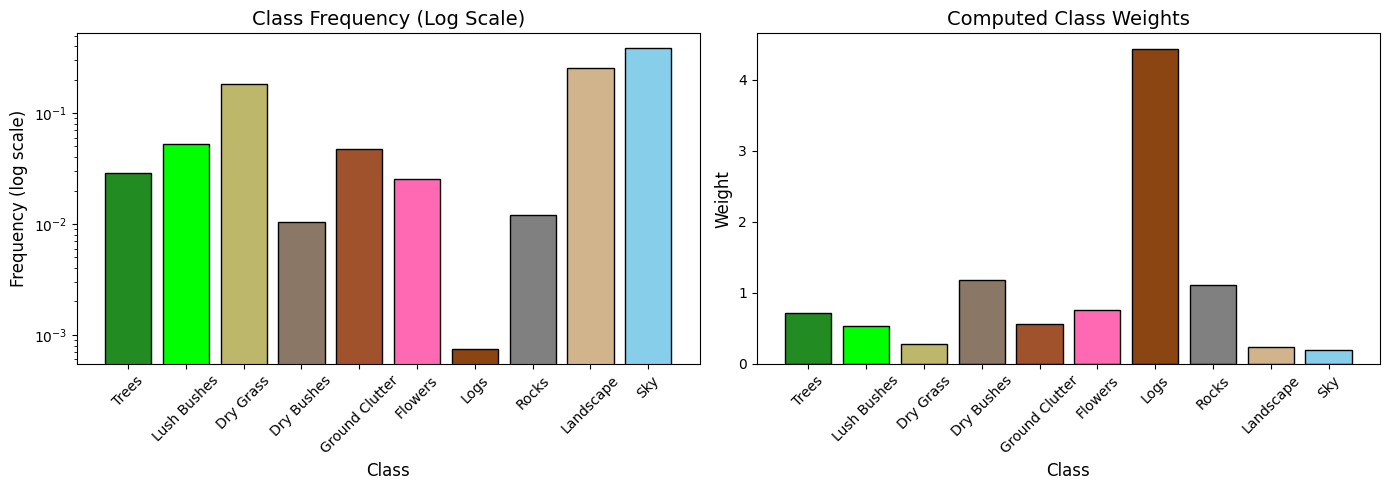


✅ Class weights tensor shape: torch.Size([10])
   Sum of weights: 10.00


In [18]:
def compute_class_weights(distribution: Dict, method: str = 'inverse') -> torch.Tensor:
    """
    Compute class weights to handle imbalance.
    
    Methods:
    - 'inverse': 1 / frequency
    - 'inverse_sqrt': 1 / sqrt(frequency)
    - 'effective': (1 - beta) / (1 - beta^n) where beta = 0.9999
    """
    class_counts = distribution['class_counts']
    total = distribution['total_pixels']
    
    weights = []
    frequencies = []
    
    for class_id in ORIGINAL_CLASS_IDS:
        count = class_counts.get(class_id, 1)  # Avoid division by zero
        freq = count / total
        frequencies.append(freq)
        
        if method == 'inverse':
            w = 1.0 / (freq + 1e-6)
        elif method == 'inverse_sqrt':
            w = 1.0 / (np.sqrt(freq) + 1e-6)
        elif method == 'effective':
            beta = 0.9999
            effective_num = 1 - np.power(beta, count)
            w = (1 - beta) / (effective_num + 1e-6)
        else:
            w = 1.0
        
        weights.append(w)
    
    # Normalize weights
    weights = np.array(weights)
    weights = weights / weights.sum() * len(weights)  # Scale to sum = num_classes
    
    return torch.tensor(weights, dtype=torch.float32), frequencies

# Compute class weights
class_weights, class_frequencies = compute_class_weights(train_distribution, method='inverse_sqrt')

print("📊 Class Weights for Loss Function:")
print("=" * 60)
print(f"{'Class':<20} {'Frequency':>12} {'Weight':>12}")
print("-" * 60)
for i, class_id in enumerate(ORIGINAL_CLASS_IDS):
    name = CLASS_INFO[class_id]['name']
    print(f"{name:<20} {class_frequencies[i]:>12.6f} {class_weights[i]:>12.4f}")
print("=" * 60)

# Visualize weights
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Frequency plot (log scale)
ax1 = axes[0]
colors = [np.array(CLASS_INFO[cid]['color']) / 255 for cid in ORIGINAL_CLASS_IDS]
ax1.bar(CLASS_NAMES, class_frequencies, color=colors, edgecolor='black')
ax1.set_yscale('log')
ax1.set_ylabel('Frequency (log scale)', fontsize=12)
ax1.set_xlabel('Class', fontsize=12)
ax1.set_title('Class Frequency (Log Scale)', fontsize=14)
ax1.tick_params(axis='x', rotation=45)

# Weight plot
ax2 = axes[1]
ax2.bar(CLASS_NAMES, class_weights.numpy(), color=colors, edgecolor='black')
ax2.set_ylabel('Weight', fontsize=12)
ax2.set_xlabel('Class', fontsize=12)
ax2.set_title('Computed Class Weights', fontsize=14)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\n✅ Class weights tensor shape: {class_weights.shape}")
print(f"   Sum of weights: {class_weights.sum():.2f}")

## 8. Sample Augmentation Preview

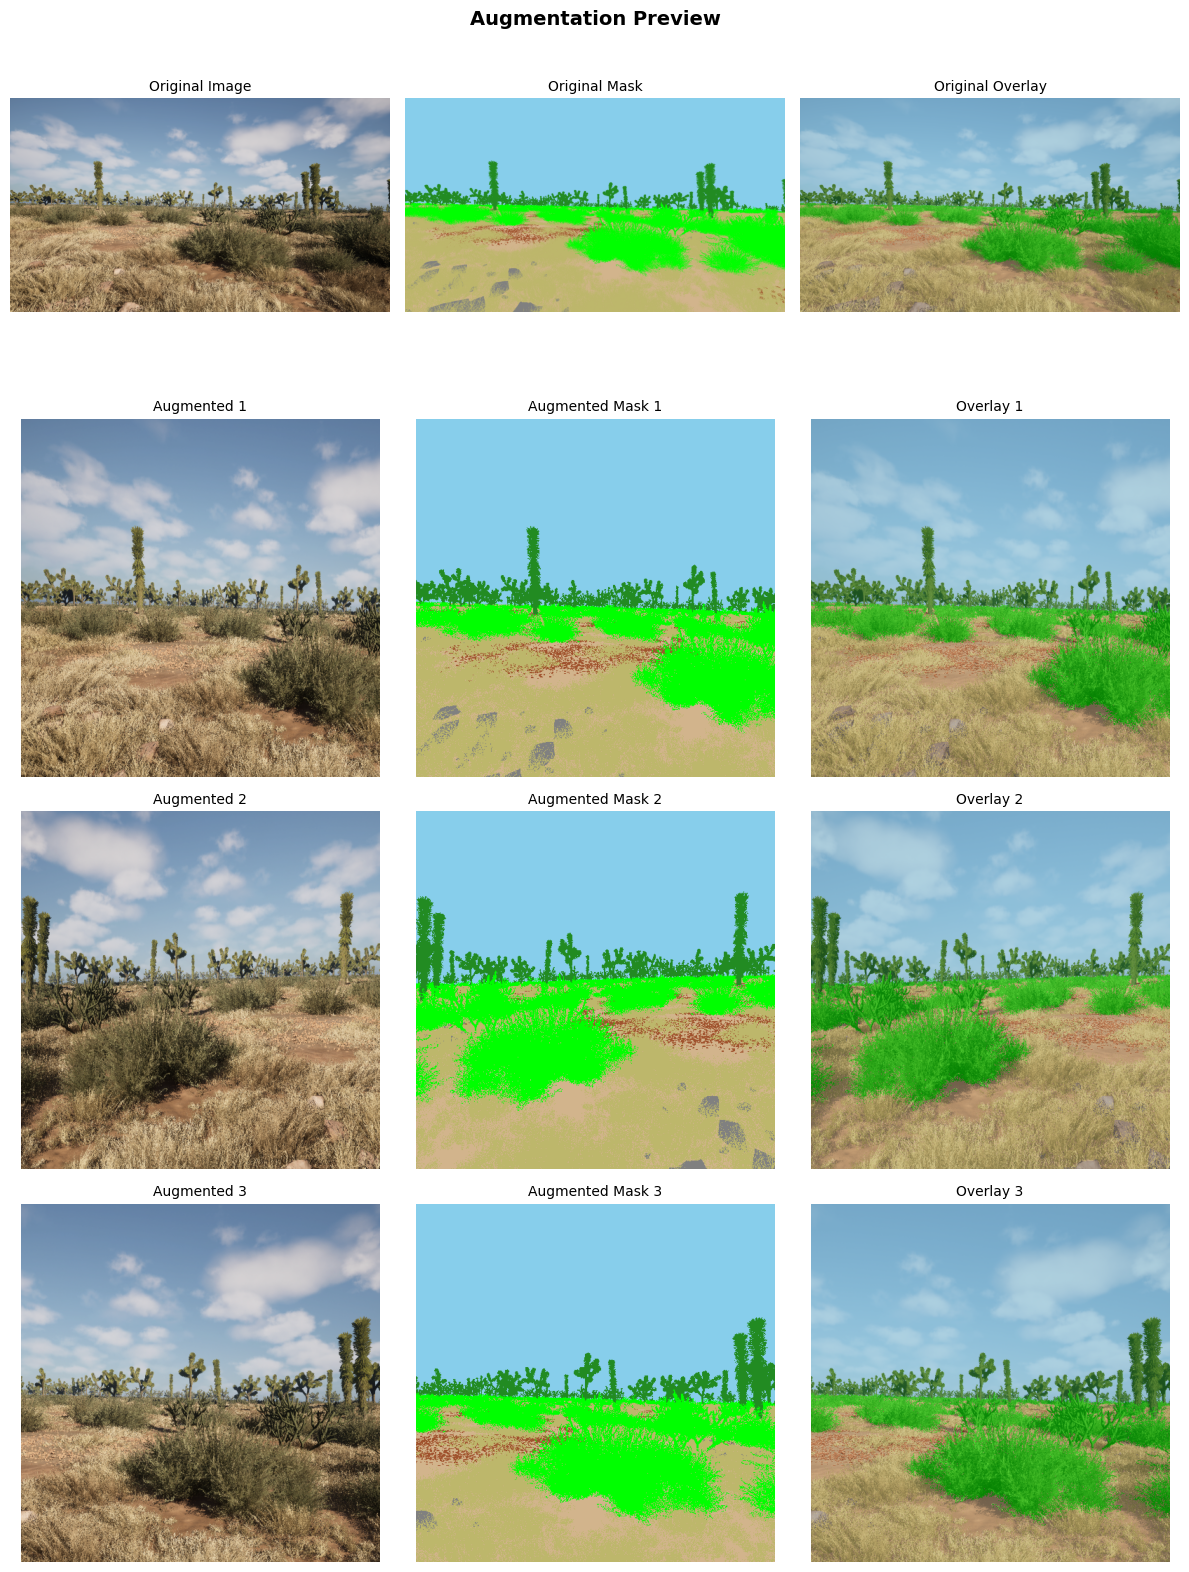

In [19]:
# Define augmentation pipeline
def get_training_augmentations(img_size: int = 512):
    """Define training augmentations using albumentations."""
    return A.Compose([
        A.RandomResizedCrop(size=(img_size, img_size), scale=(0.5, 1.0), ratio=(0.75, 1.33)),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RandomRotate90(p=0.2),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.OneOf([
            A.GaussNoise(std_range=(0.01, 0.05), p=1),
            A.GaussianBlur(blur_limit=(3, 7), p=1),
            A.MotionBlur(blur_limit=(3, 7), p=1),
        ], p=0.3),
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=1),
        ], p=0.5),
        A.Normalize(mean=IMG_MEAN, std=IMG_STD),
        ToTensorV2(),
    ])

def get_validation_augmentations(img_size: int = 512):
    """Define validation augmentations (only resize and normalize)."""
    return A.Compose([
        A.Resize(height=img_size, width=img_size),
        A.Normalize(mean=IMG_MEAN, std=IMG_STD),
        ToTensorV2(),
    ])

# Preview augmentations
def preview_augmentations(img_path: str, mask_path: str, num_samples: int = 4):
    """Visualize augmentation effects on a single image."""
    img = np.array(Image.open(img_path))
    mask = np.array(Image.open(mask_path))
    if len(mask.shape) == 3:
        mask = mask[:, :, 0]
    
    # Create augmentation without normalization for visualization
    aug_preview = A.Compose([
        A.RandomResizedCrop(size=(512, 512), scale=(0.5, 1.0)),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    ])
    
    fig, axes = plt.subplots(num_samples + 1, 3, figsize=(12, 4 * (num_samples + 1)))
    
    # Original
    axes[0, 0].imshow(img)
    axes[0, 0].set_title('Original Image', fontsize=10)
    axes[0, 0].axis('off')
    axes[0, 1].imshow(mask_to_rgb(mask))
    axes[0, 1].set_title('Original Mask', fontsize=10)
    axes[0, 1].axis('off')
    axes[0, 2].imshow(img)
    axes[0, 2].imshow(mask_to_rgb(mask), alpha=0.5)
    axes[0, 2].set_title('Original Overlay', fontsize=10)
    axes[0, 2].axis('off')
    
    # Augmented samples
    for i in range(num_samples):
        augmented = aug_preview(image=img, mask=mask)
        aug_img = augmented['image']
        aug_mask = augmented['mask']
        
        axes[i + 1, 0].imshow(aug_img)
        axes[i + 1, 0].set_title(f'Augmented {i + 1}', fontsize=10)
        axes[i + 1, 0].axis('off')
        axes[i + 1, 1].imshow(mask_to_rgb(aug_mask))
        axes[i + 1, 1].set_title(f'Augmented Mask {i + 1}', fontsize=10)
        axes[i + 1, 1].axis('off')
        axes[i + 1, 2].imshow(aug_img)
        axes[i + 1, 2].imshow(mask_to_rgb(aug_mask), alpha=0.5)
        axes[i + 1, 2].set_title(f'Overlay {i + 1}', fontsize=10)
        axes[i + 1, 2].axis('off')
    
    plt.suptitle('Augmentation Preview', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Preview on a sample image
sample_img, sample_mask = random.choice(train_pairs)
preview_augmentations(sample_img, sample_mask, num_samples=3)

## 9. Dataset Preprocessing Pipeline

In [ ]:
class OffroadSegmentationDataset(Dataset):
    """PyTorch Dataset for Offroad Semantic Segmentation."""
    
    def __init__(self, 
                 pairs: List[Tuple[str, str]], 
                 transform=None,
                 id_to_index: Dict[int, int] = None):
        """
        Args:
            pairs: List of (image_path, mask_path) tuples
            transform: Albumentations transform pipeline
            id_to_index: Mapping from original class IDs to indices
        """
        self.pairs = pairs
        self.transform = transform
        self.id_to_index = id_to_index or ID_TO_INDEX
    
    def __len__(self) -> int:
        return len(self.pairs)
    
    def remap_mask(self, mask: np.ndarray) -> np.ndarray:
        """Remap original class IDs to contiguous indices (0 to NUM_CLASSES-1)."""
        remapped = np.zeros_like(mask, dtype=np.int64)
        
        for orig_id, new_idx in self.id_to_index.items():
            remapped[mask == orig_id] = new_idx
        
        return remapped
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        img_path, mask_path = self.pairs[idx]
        
        # Load image and mask
        image = np.array(Image.open(img_path).convert('RGB'))
        mask = np.array(Image.open(mask_path))
        
        # Handle multi-channel masks
        if len(mask.shape) == 3:
            mask = mask[:, :, 0]
        
        # Remap mask to contiguous indices
        mask = self.remap_mask(mask)
        
        # Apply transforms
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].long()
        else:
            image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
            mask = torch.from_numpy(mask).long()
        
        return image, mask

# Test dataset
IMG_SIZE = 512
train_transform = get_training_augmentations(IMG_SIZE)
val_transform = get_validation_augmentations(IMG_SIZE)

train_dataset = OffroadSegmentationDataset(train_pairs, transform=train_transform)
val_dataset = OffroadSegmentationDataset(val_pairs, transform=val_transform)

print(f"📦 Dataset Statistics:")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")

# Test a sample
img, mask = train_dataset[0]
print(f"\n📐 Sample shapes:")
print(f"  Image: {img.shape} (C, H, W)")
print(f"  Mask: {mask.shape} (H, W)")
print(f"  Mask unique values: {torch.unique(mask).tolist()}")

📦 Dataset Statistics:
  Training samples: 2857
  Validation samples: 317

📐 Sample shapes:
  Image: torch.Size([3, 512, 512]) (C, H, W)
  Mask: torch.Size([512, 512]) (H, W)
  Mask unique values: [1, 2, 3, 4, 7, 8, 9]
  Mask unique values: [1, 2, 3, 4, 7, 8, 9]


: 

In [ ]:
# Create DataLoaders
BATCH_SIZE = 8
NUM_WORKERS = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"📊 DataLoader Statistics:")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Batch size: {BATCH_SIZE}")

# Verify a batch
batch_img, batch_mask = next(iter(train_loader))
print(f"\n📐 Batch shapes:")
print(f"  Images: {batch_img.shape}")
print(f"  Masks: {batch_mask.shape}")

📊 DataLoader Statistics:
  Training batches: 357
  Validation batches: 40
  Batch size: 8


## 10. Model Architecture Definition

In [ ]:
def create_model(architecture: str = 'deeplabv3plus', 
                 encoder: str = 'resnet50',
                 num_classes: int = NUM_CLASSES,
                 pretrained: bool = True) -> nn.Module:
    """
    Create a semantic segmentation model using segmentation_models_pytorch.
    
    Args:
        architecture: Model architecture ('deeplabv3plus', 'unet', 'fpn', 'pspnet')
        encoder: Backbone encoder ('resnet50', 'resnet101', 'efficientnet-b4', etc.)
        num_classes: Number of output classes
        pretrained: Use ImageNet pretrained weights
    
    Returns:
        PyTorch model
    """
    encoder_weights = 'imagenet' if pretrained else None
    
    if architecture == 'deeplabv3plus':
        model = smp.DeepLabV3Plus(
            encoder_name=encoder,
            encoder_weights=encoder_weights,
            in_channels=3,
            classes=num_classes,
        )
    elif architecture == 'unet':
        model = smp.Unet(
            encoder_name=encoder,
            encoder_weights=encoder_weights,
            in_channels=3,
            classes=num_classes,
        )
    elif architecture == 'unetplusplus':
        model = smp.UnetPlusPlus(
            encoder_name=encoder,
            encoder_weights=encoder_weights,
            in_channels=3,
            classes=num_classes,
        )
    elif architecture == 'fpn':
        model = smp.FPN(
            encoder_name=encoder,
            encoder_weights=encoder_weights,
            in_channels=3,
            classes=num_classes,
        )
    elif architecture == 'pspnet':
        model = smp.PSPNet(
            encoder_name=encoder,
            encoder_weights=encoder_weights,
            in_channels=3,
            classes=num_classes,
        )
    else:
        raise ValueError(f"Unknown architecture: {architecture}")
    
    return model

# Create the model
MODEL_ARCHITECTURE = 'deeplabv3plus'  # Options: 'deeplabv3plus', 'unet', 'unetplusplus', 'fpn', 'pspnet'
ENCODER = 'resnet50'  # Options: 'resnet50', 'resnet101', 'efficientnet-b4', 'timm-efficientnet-b5'

model = create_model(
    architecture=MODEL_ARCHITECTURE,
    encoder=ENCODER,
    num_classes=NUM_CLASSES,
    pretrained=True
)

model = model.to(device)

# Model summary
print(f"🏗️ Model Architecture: {MODEL_ARCHITECTURE}")
print(f"📦 Encoder: {ENCODER}")
print(f"🎯 Number of classes: {NUM_CLASSES}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n📊 Model Parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")

# Test forward pass
with torch.no_grad():
    test_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
    test_output = model(test_input)
    print(f"\n✅ Forward pass successful!")
    print(f"  Input shape: {test_input.shape}")
    print(f"  Output shape: {test_output.shape}")

## 11. Training Configuration and Hyperparameters

In [ ]:
# Loss Functions
class DiceLoss(nn.Module):
    """Dice Loss for semantic segmentation."""
    
    def __init__(self, smooth: float = 1.0, ignore_index: int = -1):
        super().__init__()
        self.smooth = smooth
        self.ignore_index = ignore_index
    
    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        probs = F.softmax(logits, dim=1)
        num_classes = probs.shape[1]
        
        # One-hot encode targets
        targets_one_hot = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float()
        
        # Compute dice for each class
        dims = (0, 2, 3)  # Batch, Height, Width
        intersection = (probs * targets_one_hot).sum(dim=dims)
        cardinality = (probs + targets_one_hot).sum(dim=dims)
        
        dice_score = (2.0 * intersection + self.smooth) / (cardinality + self.smooth)
        
        return 1.0 - dice_score.mean()


class CombinedLoss(nn.Module):
    """Combined Cross-Entropy and Dice Loss."""
    
    def __init__(self, 
                 class_weights: torch.Tensor = None,
                 ce_weight: float = 0.5,
                 dice_weight: float = 0.5):
        super().__init__()
        self.ce_weight = ce_weight
        self.dice_weight = dice_weight
        
        if class_weights is not None:
            self.ce_loss = nn.CrossEntropyLoss(weight=class_weights)
        else:
            self.ce_loss = nn.CrossEntropyLoss()
        
        self.dice_loss = DiceLoss()
    
    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        ce = self.ce_loss(logits, targets)
        dice = self.dice_loss(logits, targets)
        return self.ce_weight * ce + self.dice_weight * dice


# Hyperparameters
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 50
GRAD_ACCUMULATION_STEPS = 2

# Create optimizer
optimizer = AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Create scheduler
scheduler = CosineAnnealingLR(
    optimizer,
    T_max=NUM_EPOCHS,
    eta_min=1e-6
)

# Create loss function with class weights
criterion = CombinedLoss(
    class_weights=class_weights.to(device),
    ce_weight=0.5,
    dice_weight=0.5
)

# Mixed precision scaler
scaler = GradScaler()

print("⚙️ Training Configuration:")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Weight Decay: {WEIGHT_DECAY}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Gradient Accumulation Steps: {GRAD_ACCUMULATION_STEPS}")
print(f"  Effective Batch Size: {BATCH_SIZE * GRAD_ACCUMULATION_STEPS}")
print(f"  Optimizer: AdamW")
print(f"  Scheduler: CosineAnnealingLR")
print(f"  Loss: Combined CE + Dice (weighted)")

## 12. Model Training with Loss Tracking

In [ ]:
def compute_iou(pred: torch.Tensor, target: torch.Tensor, num_classes: int) -> Tuple[float, List[float]]:
    """
    Compute IoU (Intersection over Union) for each class and mean IoU.
    
    Args:
        pred: Predicted class indices (B, H, W)
        target: Ground truth class indices (B, H, W)
        num_classes: Number of classes
    
    Returns:
        Tuple of (mean_iou, per_class_iou_list)
    """
    iou_per_class = []
    
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        
        intersection = (pred_cls & target_cls).sum().float()
        union = (pred_cls | target_cls).sum().float()
        
        if union > 0:
            iou = intersection / union
        else:
            iou = torch.tensor(float('nan'))  # No pixels of this class
        
        iou_per_class.append(iou.item())
    
    # Mean IoU (ignoring NaN values)
    valid_ious = [iou for iou in iou_per_class if not np.isnan(iou)]
    mean_iou = np.mean(valid_ious) if valid_ious else 0.0
    
    return mean_iou, iou_per_class


def train_one_epoch(model, loader, criterion, optimizer, scaler, device, accumulation_steps=1):
    """Train for one epoch."""
    model.train()
    total_loss = 0.0
    all_preds = []
    all_targets = []
    
    optimizer.zero_grad()
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for batch_idx, (images, masks) in enumerate(pbar):
        images = images.to(device)
        masks = masks.to(device)
        
        # Mixed precision forward pass
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, masks) / accumulation_steps
        
        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        
        if (batch_idx + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        total_loss += loss.item() * accumulation_steps
        
        # Store predictions for IoU calculation
        preds = outputs.argmax(dim=1).cpu()
        all_preds.append(preds)
        all_targets.append(masks.cpu())
        
        pbar.set_postfix({'loss': f'{loss.item() * accumulation_steps:.4f}'})
    
    # Compute metrics
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    mean_iou, per_class_iou = compute_iou(all_preds, all_targets, NUM_CLASSES)
    
    avg_loss = total_loss / len(loader)
    return avg_loss, mean_iou, per_class_iou


@torch.no_grad()
def validate(model, loader, criterion, device):
    """Validate the model."""
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []
    
    pbar = tqdm(loader, desc='Validating', leave=False)
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)
        
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, masks)
        
        total_loss += loss.item()
        
        preds = outputs.argmax(dim=1).cpu()
        all_preds.append(preds)
        all_targets.append(masks.cpu())
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Compute metrics
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    mean_iou, per_class_iou = compute_iou(all_preds, all_targets, NUM_CLASSES)
    
    avg_loss = total_loss / len(loader)
    return avg_loss, mean_iou, per_class_iou


print("✅ Training and validation functions defined!")

In [ ]:
# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                scaler, device, num_epochs, save_dir='checkpoints'):
    """Full training loop with checkpointing."""
    
    os.makedirs(save_dir, exist_ok=True)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_miou': [],
        'val_miou': [],
        'train_class_iou': [],
        'val_class_iou': [],
        'lr': []
    }
    
    best_val_miou = 0.0
    best_epoch = 0
    
    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"{'='*60}")
        
        # Training
        train_loss, train_miou, train_class_iou = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, GRAD_ACCUMULATION_STEPS
        )
        
        # Validation
        val_loss, val_miou, val_class_iou = validate(
            model, val_loader, criterion, device
        )
        
        # Update scheduler
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_miou'].append(train_miou)
        history['val_miou'].append(val_miou)
        history['train_class_iou'].append(train_class_iou)
        history['val_class_iou'].append(val_class_iou)
        history['lr'].append(current_lr)
        
        # Print metrics
        print(f"\n📊 Results:")
        print(f"  Train Loss: {train_loss:.4f} | Train mIoU: {train_miou:.4f}")
        print(f"  Val Loss:   {val_loss:.4f} | Val mIoU:   {val_miou:.4f}")
        print(f"  Learning Rate: {current_lr:.6f}")
        
        # Save best model
        if val_miou > best_val_miou:
            best_val_miou = val_miou
            best_epoch = epoch + 1
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_miou': val_miou,
                'history': history
            }, os.path.join(save_dir, 'best_model.pth'))
            print(f"  ✅ New best model saved! (mIoU: {val_miou:.4f})")
        
        # Save periodic checkpoint
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'history': history
            }, os.path.join(save_dir, f'checkpoint_epoch_{epoch + 1}.pth'))
    
    print(f"\n🏆 Training Complete!")
    print(f"   Best Validation mIoU: {best_val_miou:.4f} at Epoch {best_epoch}")
    
    return history

print("✅ Training loop defined!")

In [ ]:
# Start training (uncomment to run)
# history = train_model(
#     model=model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     criterion=criterion,
#     optimizer=optimizer,
#     scheduler=scheduler,
#     scaler=scaler,
#     device=device,
#     num_epochs=NUM_EPOCHS,
#     save_dir=os.path.join(BASE_PATH, 'checkpoints')
# )

# For demonstration, let's run a quick training test (2 epochs)
print("🚀 Running quick training test (2 epochs)...")
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    scaler=scaler,
    device=device,
    num_epochs=2,  # Quick test
    save_dir=os.path.join(BASE_PATH, 'checkpoints')
)

## 13. Validation on Held-Out Data

In [ ]:
# Load best model and validate
def load_best_model(model, checkpoint_path):
    """Load the best model checkpoint."""
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"✅ Loaded best model from epoch {checkpoint['epoch'] + 1}")
        print(f"   Validation mIoU: {checkpoint['val_miou']:.4f}")
        return checkpoint.get('history', None)
    else:
        print("⚠️ No checkpoint found, using current model")
        return None

# Load best model
checkpoint_path = os.path.join(BASE_PATH, 'checkpoints', 'best_model.pth')
saved_history = load_best_model(model, checkpoint_path)

# Final validation
print("\n📊 Final Validation on Held-Out Data:")
val_loss, val_miou, val_class_iou = validate(model, val_loader, criterion, device)
print(f"  Validation Loss: {val_loss:.4f}")
print(f"  Validation mIoU: {val_miou:.4f}")

## 14. IoU Score Calculation per Class

In [ ]:
def detailed_iou_analysis(model, loader, device, num_classes):
    """Compute detailed IoU analysis with confusion matrix."""
    model.eval()
    
    confusion_matrix = torch.zeros(num_classes, num_classes, dtype=torch.long)
    
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Computing IoU"):
            images = images.to(device)
            
            with autocast():
                outputs = model(images)
            
            preds = outputs.argmax(dim=1).cpu()
            masks = masks.cpu()
            
            # Update confusion matrix
            for pred, target in zip(preds, masks):
                pred_flat = pred.view(-1)
                target_flat = target.view(-1)
                
                for t, p in zip(target_flat, pred_flat):
                    confusion_matrix[t.long(), p.long()] += 1
    
    # Compute IoU from confusion matrix
    per_class_iou = []
    for i in range(num_classes):
        tp = confusion_matrix[i, i].item()
        fp = confusion_matrix[:, i].sum().item() - tp
        fn = confusion_matrix[i, :].sum().item() - tp
        
        iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0.0
        per_class_iou.append(iou)
    
    return per_class_iou, confusion_matrix

# Compute detailed IoU
print("📊 Computing Detailed IoU Analysis...")
per_class_iou, conf_matrix = detailed_iou_analysis(model, val_loader, device, NUM_CLASSES)

# Display per-class IoU
print("\n📊 Per-Class IoU Scores:")
print("=" * 50)
print(f"{'Class':<20} {'IoU':>12}")
print("-" * 50)
for i, (class_id, iou) in enumerate(zip(ORIGINAL_CLASS_IDS, per_class_iou)):
    name = CLASS_INFO[class_id]['name']
    print(f"{name:<20} {iou:>12.4f}")
print("-" * 50)
mean_iou = np.mean([iou for iou in per_class_iou if iou > 0])
print(f"{'Mean IoU':<20} {mean_iou:>12.4f}")

# Plot per-class IoU
fig, ax = plt.subplots(figsize=(12, 6))
colors = [np.array(CLASS_INFO[cid]['color']) / 255 for cid in ORIGINAL_CLASS_IDS]
bars = ax.bar(CLASS_NAMES, per_class_iou, color=colors, edgecolor='black', linewidth=1)

# Add value labels on bars
for bar, iou in zip(bars, per_class_iou):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{iou:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.axhline(y=mean_iou, color='red', linestyle='--', linewidth=2, label=f'Mean IoU: {mean_iou:.4f}')
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('IoU Score', fontsize=12)
ax.set_title('Per-Class IoU Scores', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.1)
ax.tick_params(axis='x', rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))

# Normalize confusion matrix
conf_matrix_norm = conf_matrix.float() / conf_matrix.sum(dim=1, keepdim=True)
conf_matrix_norm = torch.nan_to_num(conf_matrix_norm, nan=0.0)

sns.heatmap(
    conf_matrix_norm.numpy(),
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
    ax=ax,
    cbar_kws={'label': 'Proportion'}
)

ax.set_xlabel('Predicted Class', fontsize=12)
ax.set_ylabel('True Class', fontsize=12)
ax.set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 15. Loss and Metric Visualization

In [ ]:
def plot_training_history(history):
    """Plot training history including loss, IoU, and learning rate."""
    if history is None or len(history['train_loss']) == 0:
        print("⚠️ No training history available")
        return
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Loss curves
    ax1 = axes[0, 0]
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: mIoU curves
    ax2 = axes[0, 1]
    ax2.plot(epochs, history['train_miou'], 'b-', label='Train mIoU', linewidth=2)
    ax2.plot(epochs, history['val_miou'], 'r-', label='Val mIoU', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('mIoU', fontsize=12)
    ax2.set_title('Training and Validation mIoU', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Learning rate
    ax3 = axes[1, 0]
    ax3.plot(epochs, history['lr'], 'g-', linewidth=2)
    ax3.set_xlabel('Epoch', fontsize=12)
    ax3.set_ylabel('Learning Rate', fontsize=12)
    ax3.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Per-class IoU progression (final epoch)
    ax4 = axes[1, 1]
    if history['val_class_iou']:
        final_class_iou = history['val_class_iou'][-1]
        colors = [np.array(CLASS_INFO[cid]['color']) / 255 for cid in ORIGINAL_CLASS_IDS]
        bars = ax4.bar(CLASS_NAMES, final_class_iou, color=colors, edgecolor='black')
        ax4.set_xlabel('Class', fontsize=12)
        ax4.set_ylabel('IoU', fontsize=12)
        ax4.set_title('Final Per-Class IoU', fontsize=14, fontweight='bold')
        ax4.tick_params(axis='x', rotation=45)
        ax4.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_PATH, 'training_curves.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print(f"📊 Training curves saved to {os.path.join(BASE_PATH, 'training_curves.png')}")

# Plot training history
plot_training_history(history)

## 16. Inference on Test Images

In [ ]:
def predict_single_image(model, image_path, transform, device):
    """Run inference on a single image."""
    model.eval()
    
    # Load and preprocess image
    image = np.array(Image.open(image_path).convert('RGB'))
    original_size = image.shape[:2]
    
    # Apply transform
    augmented = transform(image=image)
    input_tensor = augmented['image'].unsqueeze(0).to(device)
    
    # Inference
    with torch.no_grad():
        with autocast():
            output = model(input_tensor)
    
    # Get prediction
    pred = output.argmax(dim=1).squeeze().cpu().numpy()
    
    # Map back to original class IDs
    pred_original = np.zeros_like(pred, dtype=np.uint16)
    for idx, class_id in INDEX_TO_ID.items():
        pred_original[pred == idx] = class_id
    
    return pred, pred_original, original_size


def save_predictions(model, test_pairs, transform, device, output_dir):
    """Run inference on test images and save predictions."""
    os.makedirs(output_dir, exist_ok=True)
    
    for img_path, _ in tqdm(test_pairs, desc="Generating predictions"):
        pred, pred_original, orig_size = predict_single_image(model, img_path, transform, device)
        
        # Resize prediction to original size if needed
        if pred.shape != orig_size:
            pred_resized = np.array(Image.fromarray(pred.astype(np.uint8)).resize(
                (orig_size[1], orig_size[0]), Image.NEAREST
            ))
            pred_original_resized = np.array(Image.fromarray(pred_original.astype(np.uint16)).resize(
                (orig_size[1], orig_size[0]), Image.NEAREST
            ))
        else:
            pred_resized = pred
            pred_original_resized = pred_original
        
        # Save prediction mask (with original class IDs)
        filename = os.path.basename(img_path)
        pred_img = Image.fromarray(pred_original_resized.astype(np.uint16))
        pred_img.save(os.path.join(output_dir, filename))
    
    print(f"✅ Predictions saved to {output_dir}")

# Create test dataset
test_images = sorted(glob.glob(os.path.join(TEST_IMG_DIR, "*.png")))
print(f"📊 Found {len(test_images)} test images")

# Save predictions
output_dir = os.path.join(BASE_PATH, 'predictions')
# Uncomment to run full inference
# save_predictions(model, test_pairs, val_transform, device, output_dir)

In [ ]:
# Visualize predictions on test images
def visualize_predictions(model, pairs, transform, device, num_samples=4):
    """Visualize model predictions on sample images."""
    model.eval()
    sample_pairs = random.sample(pairs, min(num_samples, len(pairs)))
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (img_path, mask_path) in enumerate(sample_pairs):
        # Load original image and mask
        image = np.array(Image.open(img_path).convert('RGB'))
        gt_mask = np.array(Image.open(mask_path))
        if len(gt_mask.shape) == 3:
            gt_mask = gt_mask[:, :, 0]
        
        # Get prediction
        pred, _, _ = predict_single_image(model, img_path, transform, device)
        
        # Map prediction indices back for visualization
        pred_for_vis = np.zeros_like(pred, dtype=np.uint16)
        for idx_class, class_id in INDEX_TO_ID.items():
            pred_for_vis[pred == idx_class] = class_id
        
        # Display
        axes[idx, 0].imshow(image)
        axes[idx, 0].set_title('Input Image', fontsize=10)
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(mask_to_rgb(gt_mask))
        axes[idx, 1].set_title('Ground Truth', fontsize=10)
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(mask_to_rgb(pred_for_vis))
        axes[idx, 2].set_title('Prediction', fontsize=10)
        axes[idx, 2].axis('off')
        
        # Overlay prediction on image
        overlay = image.copy()
        pred_rgb = mask_to_rgb(pred_for_vis)
        # Resize pred_rgb to match image size
        pred_rgb_resized = np.array(Image.fromarray(pred_rgb).resize((image.shape[1], image.shape[0])))
        overlay = (overlay * 0.5 + pred_rgb_resized * 0.5).astype(np.uint8)
        axes[idx, 3].imshow(overlay)
        axes[idx, 3].set_title('Overlay', fontsize=10)
        axes[idx, 3].axis('off')
    
    plt.suptitle('Model Predictions on Validation Images', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_PATH, 'predictions_visualization.png'), dpi=150, bbox_inches='tight')
    plt.show()

# Visualize predictions
visualize_predictions(model, val_pairs, val_transform, device, num_samples=4)

## 17. Failure Case Analysis and Visualization

In [ ]:
def compute_pixel_accuracy_per_image(model, pairs, transform, device):
    """Compute pixel accuracy for each image to identify failure cases."""
    model.eval()
    accuracies = []
    iou_scores = []
    
    for img_path, mask_path in tqdm(pairs, desc="Computing accuracies"):
        # Load ground truth
        gt_mask = np.array(Image.open(mask_path))
        if len(gt_mask.shape) == 3:
            gt_mask = gt_mask[:, :, 0]
        
        # Get prediction
        pred, _, _ = predict_single_image(model, img_path, transform, device)
        
        # Resize prediction if needed
        if pred.shape != gt_mask.shape:
            pred_resized = np.array(Image.fromarray(pred.astype(np.uint8)).resize(
                (gt_mask.shape[1], gt_mask.shape[0]), Image.NEAREST
            ))
        else:
            pred_resized = pred
        
        # Map ground truth to indices
        gt_indices = np.zeros_like(gt_mask, dtype=np.int64)
        for class_id, idx in ID_TO_INDEX.items():
            gt_indices[gt_mask == class_id] = idx
        
        # Compute pixel accuracy
        correct = (pred_resized == gt_indices).sum()
        total = gt_indices.size
        accuracy = correct / total
        
        # Compute IoU
        intersection = 0
        union = 0
        for cls in range(NUM_CLASSES):
            pred_cls = (pred_resized == cls)
            gt_cls = (gt_indices == cls)
            intersection += (pred_cls & gt_cls).sum()
            union += (pred_cls | gt_cls).sum()
        
        iou = intersection / union if union > 0 else 0
        
        accuracies.append({
            'path': img_path,
            'accuracy': accuracy,
            'iou': iou
        })
    
    return accuracies

# Find failure cases
print("🔍 Analyzing prediction quality to identify failure cases...")
accuracies = compute_pixel_accuracy_per_image(model, val_pairs[:50], val_transform, device)

# Sort by IoU to find worst predictions
accuracies_sorted = sorted(accuracies, key=lambda x: x['iou'])

print("\n📊 Worst 10 predictions (by IoU):")
print("-" * 60)
for i, item in enumerate(accuracies_sorted[:10]):
    filename = os.path.basename(item['path'])
    print(f"{i+1:2d}. {filename:<30} IoU: {item['iou']:.4f}, Acc: {item['accuracy']:.4f}")

In [ ]:
def visualize_failure_cases(model, failure_cases, transform, device, num_samples=4):
    """Visualize failure cases with detailed error analysis."""
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4 * num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for idx, case in enumerate(failure_cases[:num_samples]):
        img_path = case['path']
        mask_path = img_path.replace('Color_Images', 'Segmentation')
        
        # Load image and ground truth
        image = np.array(Image.open(img_path).convert('RGB'))
        gt_mask = np.array(Image.open(mask_path))
        if len(gt_mask.shape) == 3:
            gt_mask = gt_mask[:, :, 0]
        
        # Get prediction
        pred, _, _ = predict_single_image(model, img_path, transform, device)
        
        # Map prediction indices back for visualization
        pred_for_vis = np.zeros_like(pred, dtype=np.uint16)
        for idx_class, class_id in INDEX_TO_ID.items():
            pred_for_vis[pred == idx_class] = class_id
        
        # Resize for comparison
        pred_rgb = mask_to_rgb(pred_for_vis)
        pred_rgb_resized = np.array(Image.fromarray(pred_rgb).resize(
            (gt_mask.shape[1], gt_mask.shape[0]), Image.NEAREST
        ))
        pred_resized = np.array(Image.fromarray(pred_for_vis.astype(np.uint16)).resize(
            (gt_mask.shape[1], gt_mask.shape[0]), Image.NEAREST
        ))
        
        # Create error map
        error_map = (gt_mask != pred_resized).astype(np.uint8) * 255
        
        # Display
        axes[idx, 0].imshow(image)
        axes[idx, 0].set_title(f'Input\nIoU: {case["iou"]:.3f}', fontsize=9)
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(mask_to_rgb(gt_mask))
        axes[idx, 1].set_title('Ground Truth', fontsize=9)
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(pred_rgb_resized)
        axes[idx, 2].set_title('Prediction', fontsize=9)
        axes[idx, 2].axis('off')
        
        axes[idx, 3].imshow(error_map, cmap='Reds')
        axes[idx, 3].set_title('Error Map (Red=Wrong)', fontsize=9)
        axes[idx, 3].axis('off')
        
        # Side-by-side comparison
        comparison = np.hstack([mask_to_rgb(gt_mask), pred_rgb_resized])
        axes[idx, 4].imshow(comparison)
        axes[idx, 4].set_title('GT (left) vs Pred (right)', fontsize=9)
        axes[idx, 4].axis('off')
    
    plt.suptitle('Failure Case Analysis - Worst Predictions', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_PATH, 'failure_analysis.png'), dpi=150, bbox_inches='tight')
    plt.show()

# Visualize failure cases
visualize_failure_cases(model, accuracies_sorted, val_transform, device, num_samples=4)

In [ ]:
# Analyze class-level confusion patterns
def analyze_class_confusion(conf_matrix, class_names):
    """Identify which classes are commonly confused with each other."""
    print("\n🔍 Class Confusion Analysis:")
    print("=" * 70)
    
    conf_matrix_np = conf_matrix.numpy().astype(float)
    
    # Normalize by row (true class)
    row_sums = conf_matrix_np.sum(axis=1, keepdims=True)
    conf_matrix_norm = np.divide(conf_matrix_np, row_sums, where=row_sums != 0)
    
    for i, class_name in enumerate(class_names):
        # Get top confusions (excluding correct predictions)
        row = conf_matrix_norm[i].copy()
        row[i] = 0  # Exclude correct prediction
        
        if row.sum() > 0.01:  # Only if there are significant misclassifications
            top_confusions = np.argsort(row)[::-1][:3]
            
            print(f"\n{class_name}:")
            for j in top_confusions:
                if row[j] > 0.01:  # Only show > 1% confusion
                    print(f"  → Confused with {class_names[j]}: {row[j]*100:.1f}%")

# Analyze confusion patterns
analyze_class_confusion(conf_matrix, CLASS_NAMES)

## 18. Model Export and Summary

In [ ]:
# Export model for deployment
def export_model(model, save_dir, img_size=512):
    """Export model in various formats."""
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    
    # 1. Save PyTorch model
    torch.save(model.state_dict(), os.path.join(save_dir, 'model_weights.pth'))
    print(f"✅ PyTorch weights saved to {os.path.join(save_dir, 'model_weights.pth')}")
    
    # 2. Save complete model
    torch.save(model, os.path.join(save_dir, 'model_complete.pth'))
    print(f"✅ Complete model saved to {os.path.join(save_dir, 'model_complete.pth')}")
    
    # 3. Export to ONNX (optional - uncomment if needed)
    # dummy_input = torch.randn(1, 3, img_size, img_size).to(device)
    # torch.onnx.export(model, dummy_input, os.path.join(save_dir, 'model.onnx'),
    #                   input_names=['input'], output_names=['output'],
    #                   dynamic_axes={'input': {0: 'batch'}, 'output': {0: 'batch'}})
    # print(f"✅ ONNX model saved to {os.path.join(save_dir, 'model.onnx')}")
    
    # 4. Save configuration
    config = {
        'architecture': MODEL_ARCHITECTURE,
        'encoder': ENCODER,
        'num_classes': NUM_CLASSES,
        'img_size': IMG_SIZE,
        'class_mapping': ID_TO_INDEX,
        'class_names': CLASS_NAMES,
        'class_info': {str(k): v for k, v in CLASS_INFO.items()},
        'normalization': {
            'mean': IMG_MEAN if 'IMG_MEAN' in dir() else [0.485, 0.456, 0.406],
            'std': IMG_STD if 'IMG_STD' in dir() else [0.229, 0.224, 0.225]
        }
    }
    
    import json
    with open(os.path.join(save_dir, 'config.json'), 'w') as f:
        json.dump(config, f, indent=2)
    print(f"✅ Config saved to {os.path.join(save_dir, 'config.json')}")

# Export model
export_dir = os.path.join(BASE_PATH, 'exported_model')
export_model(model, export_dir, IMG_SIZE)

In [ ]:
# Final Summary
print("=" * 70)
print("🏆 OFFROAD SEMANTIC SEGMENTATION - FINAL SUMMARY")
print("=" * 70)

print(f"\n📊 Dataset Statistics:")
print(f"  • Training samples: {len(train_pairs)}")
print(f"  • Validation samples: {len(val_pairs)}")
print(f"  • Test samples: {len(test_pairs) if test_pairs else 'N/A'}")
print(f"  • Number of classes: {NUM_CLASSES}")

print(f"\n🏗️ Model Configuration:")
print(f"  • Architecture: {MODEL_ARCHITECTURE}")
print(f"  • Encoder: {ENCODER}")
print(f"  • Input size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  • Parameters: {sum(p.numel() for p in model.parameters()):,}")

print(f"\n⚙️ Training Configuration:")
print(f"  • Batch size: {BATCH_SIZE}")
print(f"  • Learning rate: {LEARNING_RATE}")
print(f"  • Optimizer: AdamW")
print(f"  • Loss: Combined CE + Dice")

if history and len(history['val_miou']) > 0:
    best_epoch = np.argmax(history['val_miou']) + 1
    best_miou = max(history['val_miou'])
    final_train_loss = history['train_loss'][-1]
    final_val_loss = history['val_loss'][-1]
    
    print(f"\n📈 Training Results:")
    print(f"  • Best validation mIoU: {best_miou:.4f} (Epoch {best_epoch})")
    print(f"  • Final training loss: {final_train_loss:.4f}")
    print(f"  • Final validation loss: {final_val_loss:.4f}")

print(f"\n📁 Output Files:")
print(f"  • Checkpoints: {os.path.join(BASE_PATH, 'checkpoints')}")
print(f"  • Exported model: {os.path.join(BASE_PATH, 'exported_model')}")
print(f"  • Training curves: {os.path.join(BASE_PATH, 'training_curves.png')}")

print("\n" + "=" * 70)
print("✅ Pipeline Complete! Ready for hackathon submission.")
print("=" * 70)